In [54]:
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn
sklearn.set_config(transform_output="pandas")
import category_encoders as ce
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate
import pickle
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
df = pd.read_csv('./data/final_script.csv')
df = df.loc[:,~df.columns.str.startswith('Unnamed')]
df.head(5)

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,...,sim1_legal_question_score,sim1_conclusion_score,sim2_facts_score,sim2_issue_area_score,sim1_facts_href,sim2_facts_href,sim1_issue_area_href,sim2_issue_area_href,sim1_legal_question_href,sim1_conclusion_href
0,53057,City of Oklahoma City v. Tuttle,https://api.oyez.org/cases/1984/83-1919,83-1919,1984,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","<p>On October 10, 1980, an Oklahoma City polic...",952,7,...,0.882680,0.910945,0.880510,1.0,https://api.oyez.org/cases/1997/96-957,https://api.oyez.org/cases/2013/13-551,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/2016/16-369,https://api.oyez.org/cases/1997/96-827
1,55708,City of Ontario v. Quon,https://api.oyez.org/cases/2009/08-1332,08-1332,2009,"City of Ontario, California et al.","Jeff Quon, et al.","<p>Employees of the City of Ontario, Californi...",1494,9,...,0.889324,0.910785,0.877608,1.0,https://api.oyez.org/cases/2004/03-710,https://api.oyez.org/cases/1988/87-6571,https://api.oyez.org/cases/2011/10-637,https://api.oyez.org/cases/1999/98-1036,https://api.oyez.org/cases/1988/87-764,https://api.oyez.org/cases/2011/10-1259
2,51555,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1976/75-1150,75-1150,1976,City of Philadelphia et al.,New Jersey et al.,<p>A New Jersey statute prohibited the importa...,430,5,...,0.913905,0.892045,0.865124,1.0,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1940-1955/330us1,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1978/77-154
3,51844,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1977/77-404,77-404,1977,City of Philadelphia,New Jersey,<p>A New Jersey law prohibited the importation...,162,7,...,0.917768,0.910676,0.863157,1.0,https://api.oyez.org/cases/1976/75-1150,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/1993/93-70
4,55235,City of Rancho Palos Verdes v. Abrams,https://api.oyez.org/cases/2004/03-1601,03-1601,2004,"City of Rancho Palos Verdes, California, et al.",Mark J. Abrams,"<p>Rancho Palos Verdes, a city in California, ...",1094,9,...,0.843087,0.828414,0.884123,1.0,https://api.oyez.org/cases/2003/02-1238,https://api.oyez.org/cases/2014/13-975,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/1999/98-791,https://api.oyez.org/cases/1940-1955/341us494


In [3]:
df['fpw'] = df['first_party_winner'].map({'True': 1,'False' :0 })
min_df = df[['href', 'fpw', 'issue_area']]
sim1_facts_df = pd.merge(df, min_df, how="left", suffixes=(None, '_sim1_facts'), left_on='sim1_facts_href', right_on='href')
sim2_facts_df = pd.merge(sim1_facts_df, min_df, how="left", suffixes=(None, '_sim2_facts'), left_on='sim2_facts_href', right_on='href')

sim1_issue_area_df = pd.merge(sim2_facts_df, min_df, how="left", suffixes=(None, '_sim1_issue_area'), left_on='sim1_issue_area_href', right_on='href')
sim2_issue_area_df = pd.merge(sim1_issue_area_df, min_df, how="left", suffixes=(None, '_sim2_issue_area'), left_on='sim2_issue_area_href', right_on='href')

sim1_legal_question_df = pd.merge(sim2_issue_area_df, min_df, how="left", suffixes=(None, '_sim1_legal_question'), left_on='sim1_legal_question_href', right_on='href')

sim1_conclusion_df = pd.merge(sim1_legal_question_df, min_df, how="left", suffixes=(None, '_sim1_conclusion'), left_on='sim1_conclusion_href', right_on='href')

merged_df = sim1_conclusion_df
merged_df['fpw'] = merged_df[merged_df['fpw'].notna()]['fpw'].astype(int)
merged_df = merged_df[merged_df['fpw'].notna()]

In [4]:
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='Unnamed')))]
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='href')))]
merged_df = merged_df[merged_df['term'].str.isnumeric()]
merged_df = merged_df.drop('ID', axis=1)
merged_df = merged_df.drop('name', axis=1)
merged_df = merged_df.drop('docket', axis=1)
merged_df = merged_df.drop('facts', axis=1)
merged_df = merged_df.drop('facts_len', axis=1)
merged_df = merged_df.drop('majority_vote', axis=1)
merged_df = merged_df.drop('minority_vote', axis=1)
merged_df = merged_df.drop('disposition', axis=1)
merged_df = merged_df.drop('decision_type', axis=1)
merged_df = merged_df.drop('first_party_winner', axis=1)
merged_df = merged_df.drop('legal_question', axis=1)
merged_df = merged_df.drop('facts_clean', axis=1)
merged_df = merged_df.drop('conclusion', axis=1)
merged_df['term'] = merged_df['term'].astype('float')

merged_df.columns


Index(['term', 'first_party', 'second_party', 'issue_area',
       'first_party_entity', 'second_party_entity', 'judges', 'lower_court',
       'sim1_facts_score', 'sim1_issue_area_score',
       'sim1_legal_question_score', 'sim1_conclusion_score',
       'sim2_facts_score', 'sim2_issue_area_score', 'fpw', 'fpw_sim1_facts',
       'issue_area_sim1_facts', 'fpw_sim2_facts', 'issue_area_sim2_facts',
       'fpw_sim1_issue_area', 'issue_area_sim1_issue_area',
       'fpw_sim2_issue_area', 'issue_area_sim2_issue_area',
       'fpw_sim1_legal_question', 'issue_area_sim1_legal_question',
       'fpw_sim1_conclusion', 'issue_area_sim1_conclusion'],
      dtype='object')

In [5]:
cat_vars = ['first_party',
            'second_party',
            'issue_area',
            'first_party_entity',
            'second_party_entity',
            'judges',
            'lower_court',
            'issue_area_sim1_facts',
            'issue_area_sim2_facts',
            'issue_area_sim1_conclusion',
            'issue_area_sim1_legal_question',
            'issue_area_sim1_issue_area',
            'issue_area_sim2_issue_area']
for col in cat_vars:
    merged_df[col] = merged_df[col].astype('category')

In [6]:
merged_df.to_csv('for_training.csv')

In [7]:
# y = merged_df['fpw']
# X = merged_df.drop('fpw', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2637 entries, 0 to 2696
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   term                            2637 non-null   float64 
 1   first_party                     2636 non-null   category
 2   second_party                    2636 non-null   category
 3   issue_area                      2581 non-null   category
 4   first_party_entity              2567 non-null   category
 5   second_party_entity             2553 non-null   category
 6   judges                          2637 non-null   category
 7   lower_court                     2637 non-null   category
 8   sim1_facts_score                2637 non-null   float64 
 9   sim1_issue_area_score           2637 non-null   float64 
 10  sim1_legal_question_score       2637 non-null   float64 
 11  sim1_conclusion_score           2637 non-null   float64 
 12  sim2_facts_score         

In [12]:
#https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping
y = merged_df['fpw']
X = merged_df.drop('fpw', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    enable_categorical=True,
    tree_method='hist',
    early_stopping_rounds=10
)
parameters = {
    'max_depth': range (2, 20, 5),
    'n_estimators': range(10, 85, 5),
    'learning_rate': [0.1, 0.01, 0.05],
    'booster': ['gbtree'],
    'objective': ['binary:logistic']
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    #stratified
    cv = 10,
    verbose=10
)
# grid_search.fit(X, y)

def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator.best_estimator_, train_score, test_score

results = {}

#https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping
for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    est, train_score, test_score = fit_and_score(
        clone(estimator), X_train, X_test, y_train, y_test
    )
    results[estimator] = (train_score, test_score)

print("===========")
print(results)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[0]	validation_0-logloss:0.69020
[1]	validation_0-logloss:0.68314
[2]	validation_0-logloss:0.67917
[3]	validation_0-logloss:0.67168
[4]	validation_0-logloss:0.66360
[5]	validation_0-logloss:0.65798
[6]	validation_0-logloss:0.65577
[7]	validation_0-logloss:0.66859
[8]	validation_0-logloss:0.66473
[9]	validation_0-logloss:0.66139
[10]	validation_0-logloss:0.65697
[11]	validation_0-logloss:0.66053
[12]	validation_0-logloss:0.66547
[13]	validation_0-logloss:0.66250
[14]	validation_0-logloss:0.66360
[15]	validation_0-logloss:0.66174
[16]	validation_0-logloss:0.66063
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[0]	validation_0-logloss:0.68860
[1]	validation_0-logloss:0.68339
[2]	validation_0-logloss:0.68001
[3]	validation_0-logloss:0.67550
[4]	validation_0-logloss:0.67240
[5]	validation_0-logloss:0.66847
[6]	validation_0-logloss:0.66485
[7]	validation_0-logloss:0.66181
[8]	validation_0-logloss:0.65880
[9]	v

In [26]:
mod = list(results.keys())[0]

In [28]:
list(results.values())[0]

(0.713164886890988, 0.5819126953377244)

In [42]:
model = mod.fit(X_train, y_train, eval_set=[(X_test, y_test)])

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[0]	validation_0-logloss:0.68731
[1]	validation_0-logloss:0.68191
[2]	validation_0-logloss:0.67707
[3]	validation_0-logloss:0.67275
[4]	validation_0-logloss:0.66855
[5]	validation_0-logloss:0.66562
[6]	validation_0-logloss:0.66264
[7]	validation_0-logloss:0.66040
[8]	validation_0-logloss:0.65726
[9]	validation_0-logloss:0.65504
[10]	validation_0-logloss:0.65302
[11]	validation_0-logloss:0.65133
[12]	validation_0-logloss:0.64903
[13]	validation_0-logloss:0.64758
[14]	validation_0-logloss:0.64595
[15]	validation_0-logloss:0.64462
[16]	validation_0-logloss:0.64327
[17]	validation_0-logloss:0.64243
[18]	validation_0-logloss:0.64083
[19]	validation_0-logloss:0.63978
[20]	validation_0-logloss:0.63904
[21]	validation_0-logloss:0.63866
[22]	validation_0-logloss:0.63872
[23]	validation_0-logloss:0.63799
[24]	validation_0-logloss:0.63815
[25]	validation_0-logloss:0.63689
[26]	validation_0-logloss:0.63667
[27]	validation_0-logloss:0

In [56]:
grid_predictions = model.predict(X_test)
print(classification_report(y_test, grid_predictions))
print(confusion_matrix(y_test, grid_predictions))
# AUC as it is a function of sensitivity and specificity, the curve is insensitive to disparities in the class proportions
# https://stats.stackexchange.com/questions/235808/binary-classification-with-strongly-unbalanced-classes
print(f"roc auc: {sklearn.metrics.roc_auc_score( y_test, grid_predictions)}")

              precision    recall  f1-score   support

         0.0       0.50      0.13      0.21        89
         1.0       0.68      0.93      0.78       174

    accuracy                           0.66       263
   macro avg       0.59      0.53      0.50       263
weighted avg       0.62      0.66      0.59       263

[[ 12  77]
 [ 12 162]]
roc auc: 0.532932971716389


In [62]:
type(model.best_estimator_)

xgboost.sklearn.XGBClassifier

In [64]:
plot_importance(model)

ValueError: tree must be Booster, XGBModel or dict instance

In [63]:
mod_imps = pd.DataFrame(list(model.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)

AttributeError: 'GridSearchCV' object has no attribute 'get_booster'

ValueError: tree must be Booster, XGBModel or dict instance

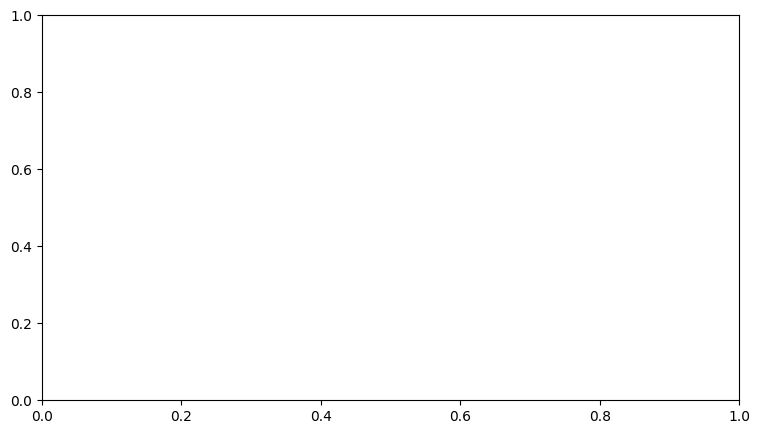

In [61]:
fig, ax = plt.subplots(figsize=(9,5))
plot_importance(model.best_estimator_.feature_importances_, ax=ax)
plt.show()

In [ ]:
# data = xgb.DMatrix(X, label=y, enable_categorical=True)
# params = {'max_depth': 5, 'eta':3, 'objective':'binary:logistic', 'n_estimators': range(10, 100, 5), 'learning_rate': [0.1, 0.01, 0.05]}
# num_round = 5

# model = XGBClassifier(max_depth=7, learning_rate=1, objective='binary:logistic', enable_categorical=True, booster='gbtree')
# model.fit(X_train, y_train)
# preds = model.predict(X_test)
# print(preds.sum())
# print(len(preds))
# print(confusion_matrix(y_test, preds))
# print(classification_report(y_test, preds))
# print(f"roc auc: {sklearn.metrics.roc_auc_score( y_test, preds)}")

In [ ]:
# estimator = XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=42,
#     enable_categorical=True
# )
# parameters = {
#     'max_depth': range (2, 20, 5),
#     'n_estimators': range(10, 85, 5),
#     'learning_rate': [0.1, 0.01, 0.05],
#     'booster': ['gbtree'],
#     'objective': ['binary:logistic']
# }
# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'aucpr',
#     n_jobs = 10,
#     #stratified
#     cv = 10,
#     verbose=10
# )
# grid_search.fit(X, y)
# print(grid_search.best_estimator_)

In [ ]:

file_name = "xgb_fpw.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

In [ ]:


# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# # test
# ind = 1
# test = X_val[ind]
# xgb_model_loaded.predict(test)[0] == xgb_model.predict(test)[0]

In [ ]:
df = pd.read_csv('./data/prediction/prediction_final_script.csv')